# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'

import pickle as pkl

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

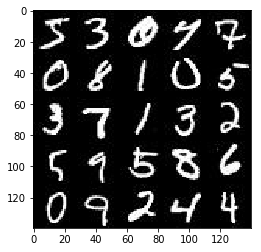

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

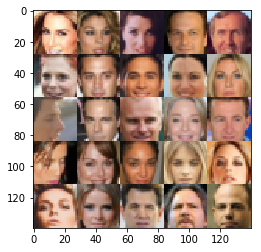

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.5.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests
import tensorflow as tf

# Rank means t
def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, [], name="learning_rate")
    
    return input_real, input_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    # Drop out rate
    drop_rate = 0.1
    # Alpha rate for leaky relu
    alpha = 0.2
    kernel_size = 3
    
    n_units = 128
    size_mult = 64
    x = images    
    
    with tf.variable_scope("discriminator", reuse=reuse):
        
        x1 = tf.layers.conv2d(x, size_mult, kernel_size, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        dropout1 = tf.layers.dropout(x1, rate=drop_rate)
        relu1 = tf.maximum(alpha * dropout1, dropout1)
        
        x2 = tf.layers.conv2d(relu1, size_mult * 2, kernel_size, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        dropout2 = tf.layers.dropout(bn2, rate=drop_rate)
        relu2 = tf.maximum(alpha * dropout2, dropout2)
      
        x3 = tf.layers.conv2d(relu2, size_mult * 4, kernel_size, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        # Flattening conv layer  
        features = tf.reshape(relu3, [-1, 4 * 4 * 256])
        
        # Set class_logits to be the inputs to a softmax distribution over the different classes
        class_logits = tf.layers.dense(features, 1, activation=None)
        
        # Sigmoid and not softmax. Sigmoid because only 2 classes.
        out = tf.nn.sigmoid(class_logits)
        
    return out, class_logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    reuse = not is_train
    alpha = 0.2
    n_units = 128
    kernel = 5
    stride = 2
    
    with tf.variable_scope("generator", reuse=reuse):
        
        # fully connected layer
        fc = tf.layers.dense(z, 2 * 2 * n_units * 4, activation=None)
        x1 = tf.reshape(fc, [-1, 2, 2, n_units * 4])   
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, n_units * 2, kernel, strides = stride, padding="valid",
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)

        x3 = tf.layers.conv2d_transpose(x2, n_units, kernel, stride, padding="same",
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, kernel, strides=stride, padding="same",
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        out = tf.tanh(logits)

        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # discriminator loss for the reals
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, 
            labels=tf.ones_like(d_model_real)
        )
    )
    
    # Discriminator loss for the fakes
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.zeros_like(d_model_fake)
        )
    )
    
    # Summing the discriminator loss for reals and fake
    total_d_loss = d_loss_real + d_loss_fake
    
    # Generator loss
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, 
            labels=tf.ones_like(d_model_fake)
        )
    )
    
    return total_d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
        
    # NN vars
    disc_vars = tf.trainable_variables("discriminator")
    gen_vars = tf.trainable_variables("generator")

    # Optimize 
    disc_trained = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list = disc_vars)
        
    updates = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in updates if opt.name.startswith("generator")]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
    
    d_train_opt = disc_trained
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
import time

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #saver = tf.train.Saver()
    sample_z = np.random.normal(-0.8, 1, size=(batch_size, z_dim))

    samples, train_accuracies, test_accuracies = [], [], []
    steps = 0    
    
    print_every = 50
    show_every = 250
    images_to_show = 25
    
    print(data_shape)
    width, height, channels = data_shape[1:]
    print("width: {}, height: {}, channels: {}".format(width, height, channels))
    print("Channel mode: {}".format(data_image_mode))
    
    
    # Getting the variables required for training 
    input_real, input_z, some_learning_rate = model_inputs(width, height, channels, z_dim)
    
    # Should use the channel mode to calculate the channels but using the number of channels works too
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    
    # Optimization
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                            
                batch_images *= 2.0
                    
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-0.8, 1, size=(batch_size, z_dim))
                
                # Run the optimizer for discriminator
                _ = sess.run(
                    d_train_opt, 
                    feed_dict={
                        input_real: batch_images, 
                        input_z: batch_z,
                        some_learning_rate:learning_rate
                    }
                )
                
                # Run the optimizer for the generator
                _ = sess.run(
                    g_train_opt,
                    feed_dict={
                        input_z: batch_z, 
                        input_real: batch_images,
                        some_learning_rate:learning_rate
                    }
                )
                
                # Print out the losses
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({
                        input_real: batch_images,
                        input_z: batch_z
                    })
                    train_loss_g = g_loss.eval({
                        input_z: batch_z, 
                        input_real: batch_images
                    })
                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                # Show the generator output
                if steps % show_every == 0:
                    show_generator_output(
                        sess,
                        images_to_show,
                        input_z, 
                        channels,
                        data_image_mode
                    )
        #saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
            


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
width: 28, height: 28, channels: 1
Channel mode: L
Epoch 1/5... Discriminator Loss: 0.4119... Generator Loss: 2.0937
Epoch 1/5... Discriminator Loss: 0.3325... Generator Loss: 5.7068
Epoch 1/5... Discriminator Loss: 0.2036... Generator Loss: 2.3678
Epoch 1/5... Discriminator Loss: 0.2076... Generator Loss: 2.6025
Epoch 1/5... Discriminator Loss: 0.4636... Generator Loss: 1.7089


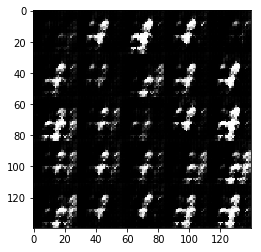

Epoch 1/5... Discriminator Loss: 0.1892... Generator Loss: 3.2705
Epoch 1/5... Discriminator Loss: 0.1092... Generator Loss: 2.9623
Epoch 1/5... Discriminator Loss: 0.0835... Generator Loss: 5.8989
Epoch 1/5... Discriminator Loss: 0.5736... Generator Loss: 1.9395
Epoch 1/5... Discriminator Loss: 0.4252... Generator Loss: 2.6925


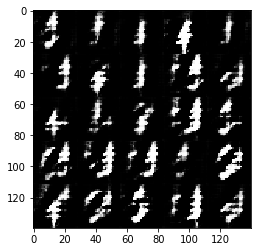

Epoch 1/5... Discriminator Loss: 0.1557... Generator Loss: 3.5714
Epoch 1/5... Discriminator Loss: 0.5279... Generator Loss: 3.7941
Epoch 1/5... Discriminator Loss: 0.8345... Generator Loss: 0.9518
Epoch 1/5... Discriminator Loss: 1.4283... Generator Loss: 4.4674
Epoch 1/5... Discriminator Loss: 0.3596... Generator Loss: 1.9198


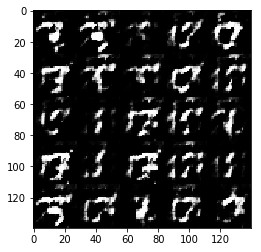

Epoch 1/5... Discriminator Loss: 0.4905... Generator Loss: 1.7849
Epoch 1/5... Discriminator Loss: 0.3019... Generator Loss: 2.2404
Epoch 1/5... Discriminator Loss: 0.6077... Generator Loss: 1.4898
Epoch 2/5... Discriminator Loss: 0.5739... Generator Loss: 2.7970
Epoch 2/5... Discriminator Loss: 1.7573... Generator Loss: 5.0297


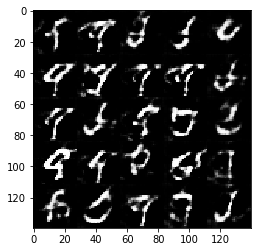

Epoch 2/5... Discriminator Loss: 0.5051... Generator Loss: 2.5165
Epoch 2/5... Discriminator Loss: 0.6918... Generator Loss: 0.8795
Epoch 2/5... Discriminator Loss: 0.8298... Generator Loss: 2.0258
Epoch 2/5... Discriminator Loss: 0.4796... Generator Loss: 1.6587
Epoch 2/5... Discriminator Loss: 0.8134... Generator Loss: 2.8391


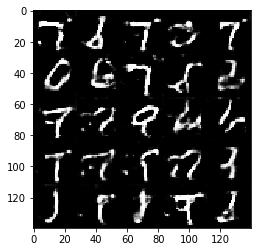

Epoch 2/5... Discriminator Loss: 5.1251... Generator Loss: 6.9142
Epoch 2/5... Discriminator Loss: 1.0683... Generator Loss: 0.6883
Epoch 2/5... Discriminator Loss: 1.0919... Generator Loss: 2.4750
Epoch 2/5... Discriminator Loss: 0.6742... Generator Loss: 1.1606
Epoch 2/5... Discriminator Loss: 0.3012... Generator Loss: 2.8003


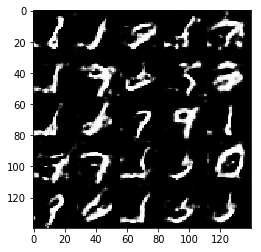

Epoch 2/5... Discriminator Loss: 1.0204... Generator Loss: 0.6472
Epoch 2/5... Discriminator Loss: 1.2804... Generator Loss: 0.5201
Epoch 2/5... Discriminator Loss: 0.4928... Generator Loss: 1.7559
Epoch 2/5... Discriminator Loss: 0.6912... Generator Loss: 0.9646
Epoch 2/5... Discriminator Loss: 0.8209... Generator Loss: 1.5823


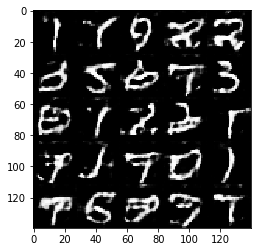

Epoch 2/5... Discriminator Loss: 1.1135... Generator Loss: 2.0487
Epoch 2/5... Discriminator Loss: 0.8488... Generator Loss: 1.6216
Epoch 3/5... Discriminator Loss: 0.8706... Generator Loss: 0.8131
Epoch 3/5... Discriminator Loss: 0.8459... Generator Loss: 1.1384
Epoch 3/5... Discriminator Loss: 0.4728... Generator Loss: 1.6642


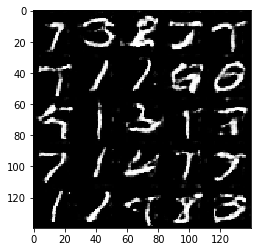

Epoch 3/5... Discriminator Loss: 0.4838... Generator Loss: 1.8192
Epoch 3/5... Discriminator Loss: 0.7788... Generator Loss: 0.8813
Epoch 3/5... Discriminator Loss: 0.3973... Generator Loss: 1.8239
Epoch 3/5... Discriminator Loss: 1.4565... Generator Loss: 0.3845
Epoch 3/5... Discriminator Loss: 0.7252... Generator Loss: 1.0539


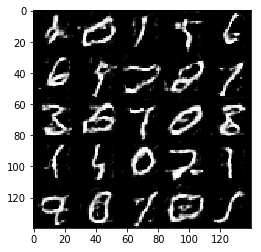

Epoch 3/5... Discriminator Loss: 0.7394... Generator Loss: 0.8592
Epoch 3/5... Discriminator Loss: 0.5806... Generator Loss: 2.0342
Epoch 3/5... Discriminator Loss: 0.5821... Generator Loss: 3.5320
Epoch 3/5... Discriminator Loss: 1.0472... Generator Loss: 0.7030
Epoch 3/5... Discriminator Loss: 1.7124... Generator Loss: 0.3321


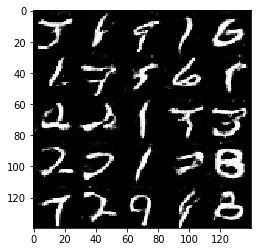

Epoch 3/5... Discriminator Loss: 0.3596... Generator Loss: 2.0784
Epoch 3/5... Discriminator Loss: 0.5248... Generator Loss: 1.4395
Epoch 3/5... Discriminator Loss: 0.4039... Generator Loss: 1.4658
Epoch 3/5... Discriminator Loss: 0.3796... Generator Loss: 1.7329
Epoch 3/5... Discriminator Loss: 0.8196... Generator Loss: 0.9528


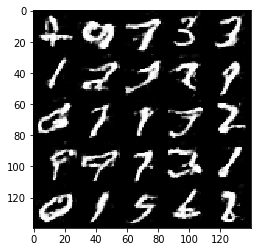

Epoch 3/5... Discriminator Loss: 0.7097... Generator Loss: 1.0041
Epoch 4/5... Discriminator Loss: 2.3660... Generator Loss: 5.0771
Epoch 4/5... Discriminator Loss: 0.6525... Generator Loss: 1.0419
Epoch 4/5... Discriminator Loss: 0.8295... Generator Loss: 3.6383
Epoch 4/5... Discriminator Loss: 0.6094... Generator Loss: 1.8202


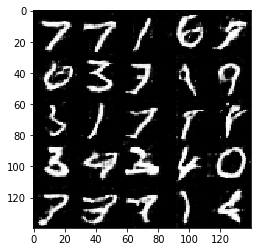

Epoch 4/5... Discriminator Loss: 0.6762... Generator Loss: 0.9938
Epoch 4/5... Discriminator Loss: 0.5490... Generator Loss: 1.2305
Epoch 4/5... Discriminator Loss: 1.2145... Generator Loss: 0.5564
Epoch 4/5... Discriminator Loss: 1.5886... Generator Loss: 5.1017
Epoch 4/5... Discriminator Loss: 0.4317... Generator Loss: 1.4307


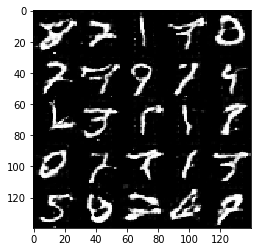

Epoch 4/5... Discriminator Loss: 0.9019... Generator Loss: 0.8327
Epoch 4/5... Discriminator Loss: 0.4640... Generator Loss: 1.8641
Epoch 4/5... Discriminator Loss: 0.5017... Generator Loss: 1.3196
Epoch 4/5... Discriminator Loss: 0.8151... Generator Loss: 0.8178
Epoch 4/5... Discriminator Loss: 0.5985... Generator Loss: 1.2425


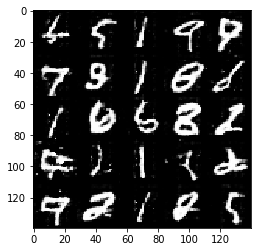

Epoch 4/5... Discriminator Loss: 0.3362... Generator Loss: 1.9289
Epoch 4/5... Discriminator Loss: 0.6898... Generator Loss: 1.7520
Epoch 4/5... Discriminator Loss: 0.3408... Generator Loss: 2.2134
Epoch 4/5... Discriminator Loss: 1.0263... Generator Loss: 0.6540
Epoch 5/5... Discriminator Loss: 0.3963... Generator Loss: 1.7947


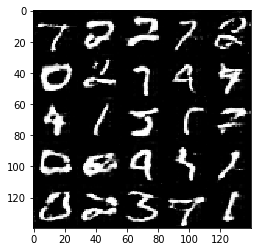

Epoch 5/5... Discriminator Loss: 0.4885... Generator Loss: 1.4557
Epoch 5/5... Discriminator Loss: 0.6173... Generator Loss: 1.1697
Epoch 5/5... Discriminator Loss: 0.6786... Generator Loss: 0.9912
Epoch 5/5... Discriminator Loss: 0.6392... Generator Loss: 1.0821
Epoch 5/5... Discriminator Loss: 0.6844... Generator Loss: 1.2188


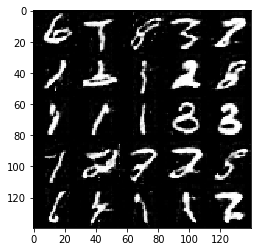

Epoch 5/5... Discriminator Loss: 0.4184... Generator Loss: 2.8429
Epoch 5/5... Discriminator Loss: 0.5437... Generator Loss: 1.8587
Epoch 5/5... Discriminator Loss: 0.8057... Generator Loss: 1.4086
Epoch 5/5... Discriminator Loss: 1.4628... Generator Loss: 0.3776
Epoch 5/5... Discriminator Loss: 0.5735... Generator Loss: 1.3434


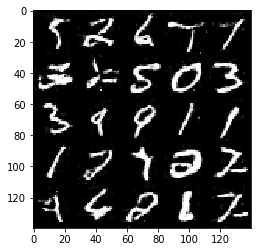

Epoch 5/5... Discriminator Loss: 0.7235... Generator Loss: 0.9807
Epoch 5/5... Discriminator Loss: 1.5306... Generator Loss: 0.5266
Epoch 5/5... Discriminator Loss: 0.8266... Generator Loss: 3.4157
Epoch 5/5... Discriminator Loss: 0.4610... Generator Loss: 1.9057
Epoch 5/5... Discriminator Loss: 0.5074... Generator Loss: 1.2430


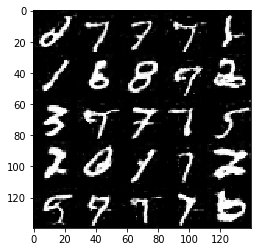

Epoch 5/5... Discriminator Loss: 0.4537... Generator Loss: 1.4421
Epoch 5/5... Discriminator Loss: 0.5801... Generator Loss: 1.2831
Epoch 5/5... Discriminator Loss: 1.5063... Generator Loss: 0.4500


In [12]:
batch_size = 64
z_dim = 110
learning_rate = 0.0008
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3)
width: 28, height: 28, channels: 3
Channel mode: RGB
Epoch 1/4... Discriminator Loss: 0.6004... Generator Loss: 0.9658
Epoch 1/4... Discriminator Loss: 0.4092... Generator Loss: 1.7876
Epoch 1/4... Discriminator Loss: 0.7055... Generator Loss: 1.3663
Epoch 1/4... Discriminator Loss: 0.6305... Generator Loss: 1.5229
Epoch 1/4... Discriminator Loss: 1.5459... Generator Loss: 0.4716


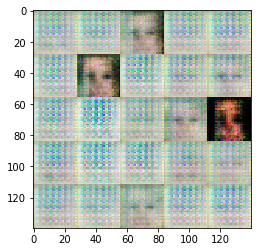

Epoch 1/4... Discriminator Loss: 1.2556... Generator Loss: 2.2382
Epoch 1/4... Discriminator Loss: 1.2682... Generator Loss: 1.1533
Epoch 1/4... Discriminator Loss: 2.0425... Generator Loss: 0.6132
Epoch 1/4... Discriminator Loss: 0.8887... Generator Loss: 1.3221
Epoch 1/4... Discriminator Loss: 1.0489... Generator Loss: 1.2575


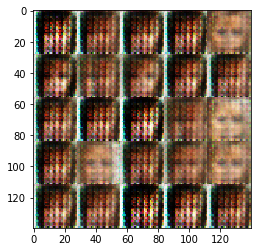

Epoch 1/4... Discriminator Loss: 0.3708... Generator Loss: 2.3979
Epoch 1/4... Discriminator Loss: 0.8049... Generator Loss: 1.1976
Epoch 1/4... Discriminator Loss: 0.9324... Generator Loss: 1.7725
Epoch 1/4... Discriminator Loss: 0.8416... Generator Loss: 2.9387
Epoch 1/4... Discriminator Loss: 1.0458... Generator Loss: 1.1535


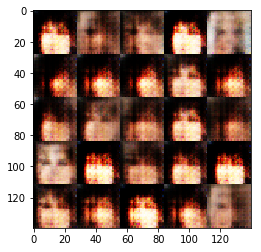

Epoch 1/4... Discriminator Loss: 1.3729... Generator Loss: 3.2271
Epoch 1/4... Discriminator Loss: 2.0775... Generator Loss: 0.2598
Epoch 1/4... Discriminator Loss: 0.9618... Generator Loss: 1.1726
Epoch 1/4... Discriminator Loss: 0.6333... Generator Loss: 1.3262
Epoch 1/4... Discriminator Loss: 1.0507... Generator Loss: 1.1728


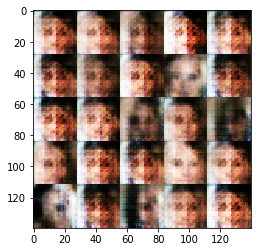

Epoch 1/4... Discriminator Loss: 0.9688... Generator Loss: 1.2723
Epoch 1/4... Discriminator Loss: 1.2975... Generator Loss: 0.7353
Epoch 1/4... Discriminator Loss: 0.9465... Generator Loss: 0.8276
Epoch 1/4... Discriminator Loss: 0.9624... Generator Loss: 1.3614
Epoch 1/4... Discriminator Loss: 0.9745... Generator Loss: 3.2782


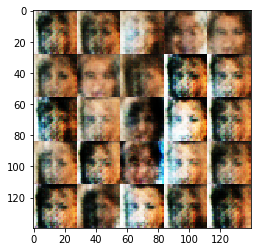

Epoch 1/4... Discriminator Loss: 0.8984... Generator Loss: 0.9278
Epoch 1/4... Discriminator Loss: 0.8660... Generator Loss: 1.9089
Epoch 1/4... Discriminator Loss: 0.7216... Generator Loss: 1.3360
Epoch 1/4... Discriminator Loss: 1.0465... Generator Loss: 1.6888
Epoch 1/4... Discriminator Loss: 1.0269... Generator Loss: 0.7260


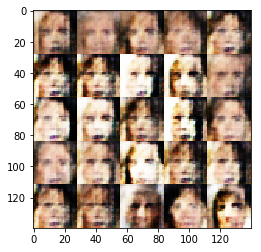

Epoch 1/4... Discriminator Loss: 0.6135... Generator Loss: 1.6503
Epoch 1/4... Discriminator Loss: 0.8141... Generator Loss: 1.2766
Epoch 1/4... Discriminator Loss: 1.0995... Generator Loss: 0.9018
Epoch 1/4... Discriminator Loss: 0.9223... Generator Loss: 1.7373
Epoch 1/4... Discriminator Loss: 0.9671... Generator Loss: 1.4973


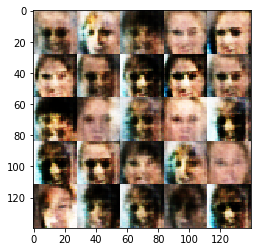

Epoch 1/4... Discriminator Loss: 0.8843... Generator Loss: 1.4061
Epoch 1/4... Discriminator Loss: 0.8944... Generator Loss: 2.8404
Epoch 1/4... Discriminator Loss: 1.1982... Generator Loss: 1.6690
Epoch 1/4... Discriminator Loss: 0.8499... Generator Loss: 0.9924
Epoch 1/4... Discriminator Loss: 0.8201... Generator Loss: 1.1831


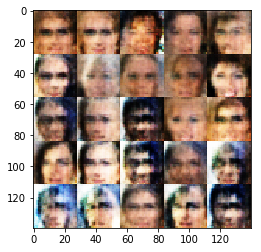

Epoch 1/4... Discriminator Loss: 0.7951... Generator Loss: 1.1948
Epoch 1/4... Discriminator Loss: 0.8445... Generator Loss: 1.1977
Epoch 1/4... Discriminator Loss: 1.1353... Generator Loss: 1.6102
Epoch 1/4... Discriminator Loss: 0.9070... Generator Loss: 2.1737
Epoch 1/4... Discriminator Loss: 1.4048... Generator Loss: 0.4589


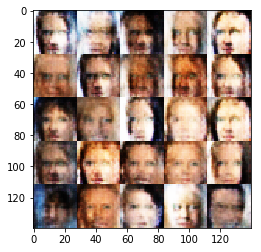

Epoch 1/4... Discriminator Loss: 1.1298... Generator Loss: 1.9701
Epoch 1/4... Discriminator Loss: 1.1712... Generator Loss: 0.6807
Epoch 1/4... Discriminator Loss: 0.8943... Generator Loss: 0.9713
Epoch 1/4... Discriminator Loss: 1.0988... Generator Loss: 1.5731
Epoch 1/4... Discriminator Loss: 0.7711... Generator Loss: 1.0794


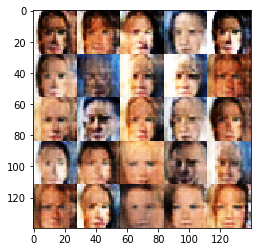

Epoch 1/4... Discriminator Loss: 1.0991... Generator Loss: 0.6884
Epoch 1/4... Discriminator Loss: 0.7800... Generator Loss: 1.4731
Epoch 1/4... Discriminator Loss: 0.8240... Generator Loss: 1.5127
Epoch 1/4... Discriminator Loss: 1.0813... Generator Loss: 0.7816
Epoch 1/4... Discriminator Loss: 0.9974... Generator Loss: 0.8014


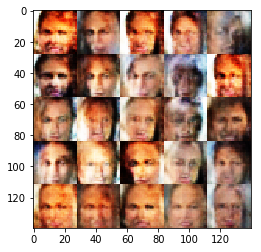

Epoch 1/4... Discriminator Loss: 1.1943... Generator Loss: 0.7001
Epoch 1/4... Discriminator Loss: 0.8663... Generator Loss: 1.5834
Epoch 1/4... Discriminator Loss: 1.0059... Generator Loss: 0.8750
Epoch 1/4... Discriminator Loss: 1.0970... Generator Loss: 1.7820
Epoch 1/4... Discriminator Loss: 1.1184... Generator Loss: 0.6697


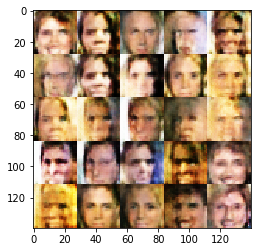

Epoch 1/4... Discriminator Loss: 0.9379... Generator Loss: 1.1647
Epoch 1/4... Discriminator Loss: 1.1936... Generator Loss: 0.9613
Epoch 1/4... Discriminator Loss: 0.8264... Generator Loss: 1.2243
Epoch 2/4... Discriminator Loss: 1.0767... Generator Loss: 0.6998
Epoch 2/4... Discriminator Loss: 1.0314... Generator Loss: 0.8660


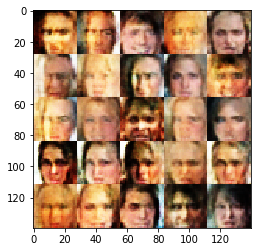

Epoch 2/4... Discriminator Loss: 0.9836... Generator Loss: 1.4902
Epoch 2/4... Discriminator Loss: 0.8266... Generator Loss: 1.5091
Epoch 2/4... Discriminator Loss: 1.5107... Generator Loss: 0.3791
Epoch 2/4... Discriminator Loss: 1.2137... Generator Loss: 2.3308
Epoch 2/4... Discriminator Loss: 0.8047... Generator Loss: 1.0456


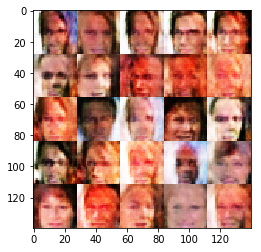

Epoch 2/4... Discriminator Loss: 1.2249... Generator Loss: 0.7950
Epoch 2/4... Discriminator Loss: 1.3400... Generator Loss: 0.5001
Epoch 2/4... Discriminator Loss: 1.5030... Generator Loss: 0.3488
Epoch 2/4... Discriminator Loss: 1.2268... Generator Loss: 0.5544
Epoch 2/4... Discriminator Loss: 1.5692... Generator Loss: 0.3990


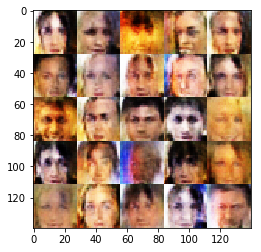

Epoch 2/4... Discriminator Loss: 1.1484... Generator Loss: 0.8601
Epoch 2/4... Discriminator Loss: 1.0957... Generator Loss: 1.6688
Epoch 2/4... Discriminator Loss: 1.3506... Generator Loss: 0.6058
Epoch 2/4... Discriminator Loss: 0.9887... Generator Loss: 0.9304
Epoch 2/4... Discriminator Loss: 1.1650... Generator Loss: 0.7854


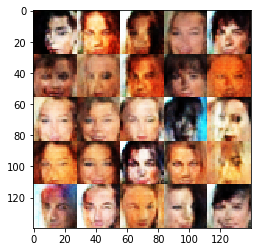

Epoch 2/4... Discriminator Loss: 0.8768... Generator Loss: 1.2650
Epoch 2/4... Discriminator Loss: 1.0274... Generator Loss: 1.5600
Epoch 2/4... Discriminator Loss: 1.0227... Generator Loss: 0.7253
Epoch 2/4... Discriminator Loss: 1.1266... Generator Loss: 0.7329
Epoch 2/4... Discriminator Loss: 1.0004... Generator Loss: 2.3480


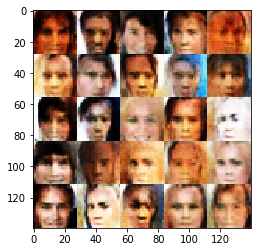

Epoch 2/4... Discriminator Loss: 0.7282... Generator Loss: 1.4298
Epoch 2/4... Discriminator Loss: 1.0812... Generator Loss: 1.0428
Epoch 2/4... Discriminator Loss: 1.0234... Generator Loss: 0.9468
Epoch 2/4... Discriminator Loss: 1.0000... Generator Loss: 0.8265
Epoch 2/4... Discriminator Loss: 0.8041... Generator Loss: 0.9633


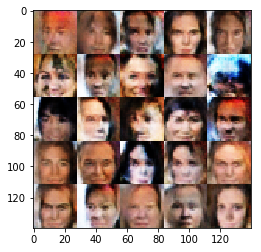

Epoch 2/4... Discriminator Loss: 0.9851... Generator Loss: 1.1606
Epoch 2/4... Discriminator Loss: 0.8671... Generator Loss: 1.1242
Epoch 2/4... Discriminator Loss: 0.8413... Generator Loss: 0.9341
Epoch 2/4... Discriminator Loss: 1.0901... Generator Loss: 0.9787
Epoch 2/4... Discriminator Loss: 0.9621... Generator Loss: 1.4652


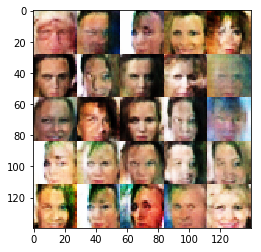

Epoch 2/4... Discriminator Loss: 1.3613... Generator Loss: 0.5184
Epoch 2/4... Discriminator Loss: 1.0872... Generator Loss: 1.8302
Epoch 2/4... Discriminator Loss: 1.0465... Generator Loss: 0.8319
Epoch 2/4... Discriminator Loss: 1.0055... Generator Loss: 0.7446
Epoch 2/4... Discriminator Loss: 1.0438... Generator Loss: 1.2645


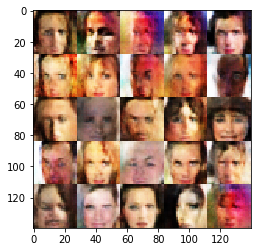

Epoch 2/4... Discriminator Loss: 1.3264... Generator Loss: 0.5116
Epoch 2/4... Discriminator Loss: 1.0740... Generator Loss: 1.4416
Epoch 2/4... Discriminator Loss: 1.0536... Generator Loss: 0.8459
Epoch 2/4... Discriminator Loss: 1.2111... Generator Loss: 1.4481
Epoch 2/4... Discriminator Loss: 1.1944... Generator Loss: 0.6257


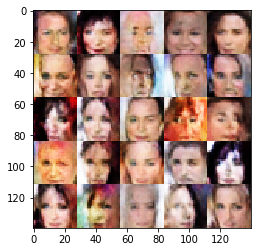

Epoch 2/4... Discriminator Loss: 0.8681... Generator Loss: 1.1716
Epoch 2/4... Discriminator Loss: 0.8426... Generator Loss: 1.9884
Epoch 2/4... Discriminator Loss: 0.9705... Generator Loss: 0.8342
Epoch 2/4... Discriminator Loss: 1.0126... Generator Loss: 1.1728
Epoch 2/4... Discriminator Loss: 0.7984... Generator Loss: 1.6653


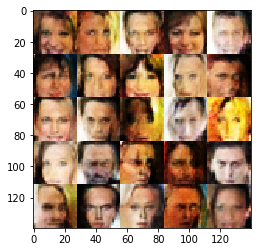

Epoch 2/4... Discriminator Loss: 1.1431... Generator Loss: 1.2565
Epoch 2/4... Discriminator Loss: 1.1072... Generator Loss: 1.1300
Epoch 2/4... Discriminator Loss: 1.1131... Generator Loss: 1.0706
Epoch 2/4... Discriminator Loss: 1.2331... Generator Loss: 0.5558
Epoch 2/4... Discriminator Loss: 0.8909... Generator Loss: 1.3785


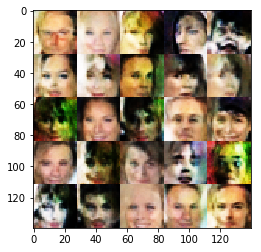

Epoch 2/4... Discriminator Loss: 0.8373... Generator Loss: 1.1891
Epoch 2/4... Discriminator Loss: 1.0299... Generator Loss: 1.1598
Epoch 2/4... Discriminator Loss: 0.9257... Generator Loss: 1.0557
Epoch 2/4... Discriminator Loss: 0.9978... Generator Loss: 1.0010
Epoch 2/4... Discriminator Loss: 1.1588... Generator Loss: 0.7553


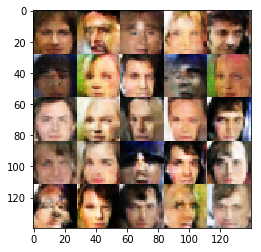

Epoch 2/4... Discriminator Loss: 1.1855... Generator Loss: 0.8210
Epoch 2/4... Discriminator Loss: 0.7929... Generator Loss: 1.5729
Epoch 2/4... Discriminator Loss: 1.3048... Generator Loss: 1.7955
Epoch 2/4... Discriminator Loss: 1.0186... Generator Loss: 1.4688
Epoch 2/4... Discriminator Loss: 1.3246... Generator Loss: 0.4620


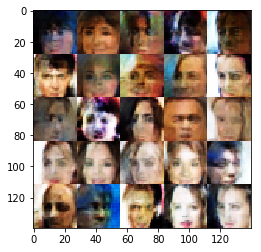

Epoch 2/4... Discriminator Loss: 1.0819... Generator Loss: 1.0586
Epoch 3/4... Discriminator Loss: 1.0302... Generator Loss: 0.9175
Epoch 3/4... Discriminator Loss: 1.2196... Generator Loss: 1.3026
Epoch 3/4... Discriminator Loss: 1.0182... Generator Loss: 1.0050
Epoch 3/4... Discriminator Loss: 1.4062... Generator Loss: 2.1082


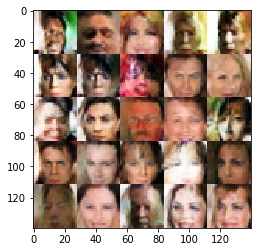

Epoch 3/4... Discriminator Loss: 1.2007... Generator Loss: 0.6347
Epoch 3/4... Discriminator Loss: 1.3898... Generator Loss: 0.4771
Epoch 3/4... Discriminator Loss: 0.9875... Generator Loss: 0.9352
Epoch 3/4... Discriminator Loss: 0.8331... Generator Loss: 1.0856
Epoch 3/4... Discriminator Loss: 0.9111... Generator Loss: 1.1337


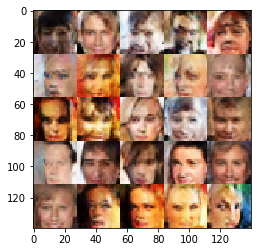

Epoch 3/4... Discriminator Loss: 0.8399... Generator Loss: 0.9365
Epoch 3/4... Discriminator Loss: 1.0690... Generator Loss: 1.1701
Epoch 3/4... Discriminator Loss: 1.1224... Generator Loss: 2.2277
Epoch 3/4... Discriminator Loss: 1.2630... Generator Loss: 2.1861
Epoch 3/4... Discriminator Loss: 0.9408... Generator Loss: 0.7326


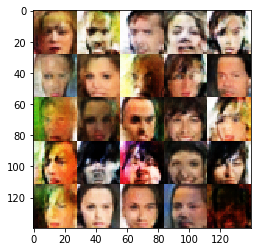

Epoch 3/4... Discriminator Loss: 1.2542... Generator Loss: 0.8926
Epoch 3/4... Discriminator Loss: 0.8418... Generator Loss: 0.9545
Epoch 3/4... Discriminator Loss: 1.1964... Generator Loss: 0.5495
Epoch 3/4... Discriminator Loss: 1.3491... Generator Loss: 0.4776
Epoch 3/4... Discriminator Loss: 1.2754... Generator Loss: 0.6739


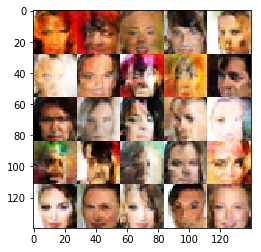

Epoch 3/4... Discriminator Loss: 1.2291... Generator Loss: 0.6522
Epoch 3/4... Discriminator Loss: 1.3930... Generator Loss: 0.3929
Epoch 3/4... Discriminator Loss: 1.7026... Generator Loss: 0.2957
Epoch 3/4... Discriminator Loss: 0.9352... Generator Loss: 1.1475
Epoch 3/4... Discriminator Loss: 0.7585... Generator Loss: 1.6931


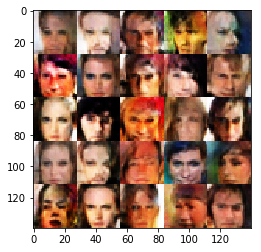

Epoch 3/4... Discriminator Loss: 1.1584... Generator Loss: 0.7482
Epoch 3/4... Discriminator Loss: 1.3667... Generator Loss: 1.2888
Epoch 3/4... Discriminator Loss: 1.8474... Generator Loss: 0.2514
Epoch 3/4... Discriminator Loss: 1.2243... Generator Loss: 0.5310
Epoch 3/4... Discriminator Loss: 1.3996... Generator Loss: 0.4130


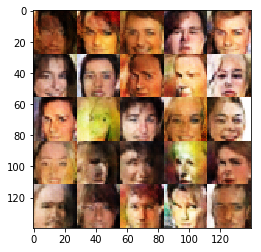

Epoch 3/4... Discriminator Loss: 1.0046... Generator Loss: 0.7785
Epoch 3/4... Discriminator Loss: 0.7988... Generator Loss: 1.4699
Epoch 3/4... Discriminator Loss: 1.1731... Generator Loss: 0.6426
Epoch 3/4... Discriminator Loss: 1.2473... Generator Loss: 1.5474
Epoch 3/4... Discriminator Loss: 0.8938... Generator Loss: 0.9941


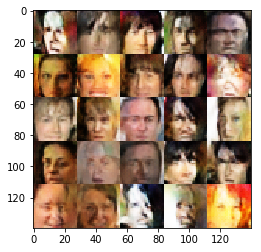

Epoch 3/4... Discriminator Loss: 0.8100... Generator Loss: 0.8229
Epoch 3/4... Discriminator Loss: 1.3588... Generator Loss: 1.2036
Epoch 3/4... Discriminator Loss: 0.9889... Generator Loss: 0.8455
Epoch 3/4... Discriminator Loss: 1.3060... Generator Loss: 0.4942
Epoch 3/4... Discriminator Loss: 1.4608... Generator Loss: 0.3806


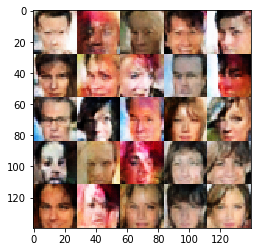

Epoch 3/4... Discriminator Loss: 1.6654... Generator Loss: 0.2850
Epoch 3/4... Discriminator Loss: 0.9104... Generator Loss: 1.9317
Epoch 3/4... Discriminator Loss: 1.4701... Generator Loss: 1.0194
Epoch 3/4... Discriminator Loss: 1.5218... Generator Loss: 1.2354
Epoch 3/4... Discriminator Loss: 0.7144... Generator Loss: 1.0842


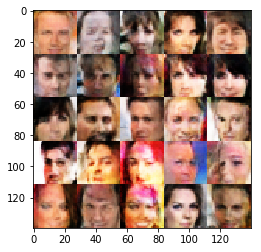

Epoch 3/4... Discriminator Loss: 0.7566... Generator Loss: 0.9428
Epoch 3/4... Discriminator Loss: 1.2836... Generator Loss: 1.2999
Epoch 3/4... Discriminator Loss: 1.2074... Generator Loss: 1.0620
Epoch 3/4... Discriminator Loss: 1.4902... Generator Loss: 0.3826
Epoch 3/4... Discriminator Loss: 1.2357... Generator Loss: 1.1358


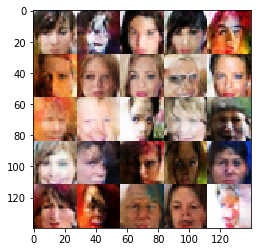

Epoch 3/4... Discriminator Loss: 1.1627... Generator Loss: 1.0791
Epoch 3/4... Discriminator Loss: 1.9303... Generator Loss: 0.2387
Epoch 3/4... Discriminator Loss: 0.9778... Generator Loss: 0.7512
Epoch 3/4... Discriminator Loss: 1.0466... Generator Loss: 1.8094
Epoch 3/4... Discriminator Loss: 2.0047... Generator Loss: 0.2241


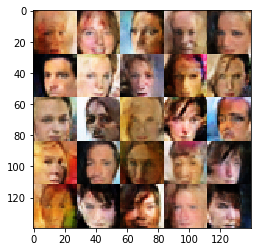

Epoch 3/4... Discriminator Loss: 1.0811... Generator Loss: 0.6736
Epoch 3/4... Discriminator Loss: 1.4928... Generator Loss: 0.9850
Epoch 3/4... Discriminator Loss: 1.1052... Generator Loss: 0.6779
Epoch 3/4... Discriminator Loss: 0.7796... Generator Loss: 1.1917
Epoch 3/4... Discriminator Loss: 1.0983... Generator Loss: 1.3764


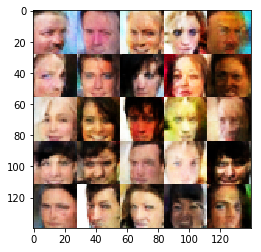

Epoch 3/4... Discriminator Loss: 0.6249... Generator Loss: 1.1967
Epoch 3/4... Discriminator Loss: 1.1920... Generator Loss: 0.9977
Epoch 3/4... Discriminator Loss: 1.5785... Generator Loss: 0.3007
Epoch 3/4... Discriminator Loss: 0.8603... Generator Loss: 0.9288
Epoch 4/4... Discriminator Loss: 1.2827... Generator Loss: 0.4798


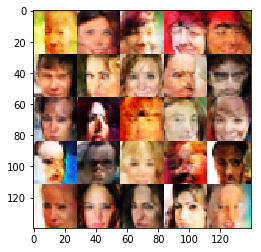

Epoch 4/4... Discriminator Loss: 0.6141... Generator Loss: 1.3584
Epoch 4/4... Discriminator Loss: 0.6255... Generator Loss: 2.2968
Epoch 4/4... Discriminator Loss: 1.4218... Generator Loss: 0.4727
Epoch 4/4... Discriminator Loss: 0.7004... Generator Loss: 1.0571
Epoch 4/4... Discriminator Loss: 0.4739... Generator Loss: 1.8298


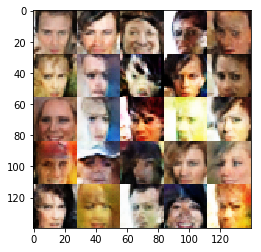

Epoch 4/4... Discriminator Loss: 1.1665... Generator Loss: 0.5151
Epoch 4/4... Discriminator Loss: 0.7541... Generator Loss: 0.9386
Epoch 4/4... Discriminator Loss: 1.2970... Generator Loss: 1.1293
Epoch 4/4... Discriminator Loss: 0.5324... Generator Loss: 1.9542
Epoch 4/4... Discriminator Loss: 0.4525... Generator Loss: 3.7020


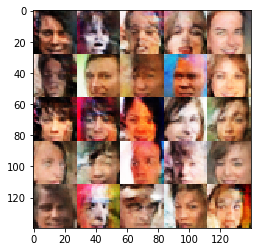

Epoch 4/4... Discriminator Loss: 1.2424... Generator Loss: 1.7925
Epoch 4/4... Discriminator Loss: 0.9534... Generator Loss: 0.7344
Epoch 4/4... Discriminator Loss: 0.9462... Generator Loss: 0.8812
Epoch 4/4... Discriminator Loss: 0.9315... Generator Loss: 0.8772
Epoch 4/4... Discriminator Loss: 0.7280... Generator Loss: 1.2558


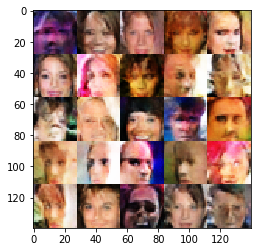

Epoch 4/4... Discriminator Loss: 1.0458... Generator Loss: 1.3972
Epoch 4/4... Discriminator Loss: 1.0805... Generator Loss: 0.6889
Epoch 4/4... Discriminator Loss: 0.5888... Generator Loss: 1.6457
Epoch 4/4... Discriminator Loss: 1.8301... Generator Loss: 0.2438
Epoch 4/4... Discriminator Loss: 1.0104... Generator Loss: 0.7701


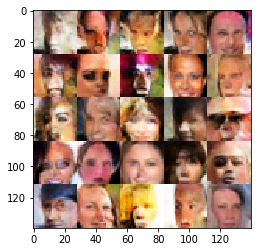

Epoch 4/4... Discriminator Loss: 1.1018... Generator Loss: 1.7008
Epoch 4/4... Discriminator Loss: 1.1228... Generator Loss: 1.0780
Epoch 4/4... Discriminator Loss: 1.6082... Generator Loss: 0.3263
Epoch 4/4... Discriminator Loss: 0.9641... Generator Loss: 0.8667
Epoch 4/4... Discriminator Loss: 0.7477... Generator Loss: 1.2598


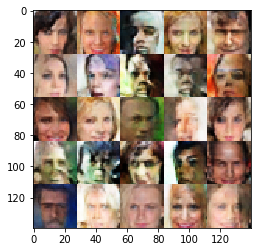

Epoch 4/4... Discriminator Loss: 1.0812... Generator Loss: 0.6997
Epoch 4/4... Discriminator Loss: 1.0802... Generator Loss: 1.5123
Epoch 4/4... Discriminator Loss: 1.1148... Generator Loss: 0.7096
Epoch 4/4... Discriminator Loss: 0.4634... Generator Loss: 1.9549
Epoch 4/4... Discriminator Loss: 0.9645... Generator Loss: 1.1024


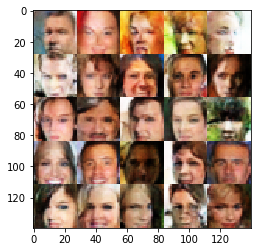

Epoch 4/4... Discriminator Loss: 0.3243... Generator Loss: 1.7414
Epoch 4/4... Discriminator Loss: 1.0117... Generator Loss: 0.8755
Epoch 4/4... Discriminator Loss: 1.3296... Generator Loss: 1.1114
Epoch 4/4... Discriminator Loss: 1.4656... Generator Loss: 0.3900
Epoch 4/4... Discriminator Loss: 0.8300... Generator Loss: 1.1992


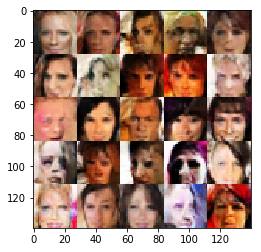

Epoch 4/4... Discriminator Loss: 0.9786... Generator Loss: 1.3129
Epoch 4/4... Discriminator Loss: 1.2664... Generator Loss: 0.6908
Epoch 4/4... Discriminator Loss: 1.1389... Generator Loss: 0.5860
Epoch 4/4... Discriminator Loss: 0.5264... Generator Loss: 1.8797
Epoch 4/4... Discriminator Loss: 1.6651... Generator Loss: 0.2982


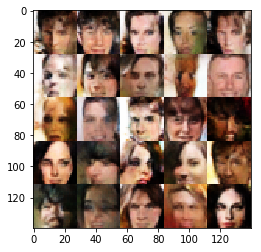

Epoch 4/4... Discriminator Loss: 1.6235... Generator Loss: 0.3860
Epoch 4/4... Discriminator Loss: 0.7975... Generator Loss: 1.2214
Epoch 4/4... Discriminator Loss: 0.6462... Generator Loss: 1.4604
Epoch 4/4... Discriminator Loss: 1.7924... Generator Loss: 0.4121
Epoch 4/4... Discriminator Loss: 0.7935... Generator Loss: 0.8142


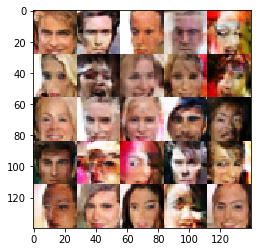

Epoch 4/4... Discriminator Loss: 0.9952... Generator Loss: 1.5478
Epoch 4/4... Discriminator Loss: 0.1812... Generator Loss: 3.1668
Epoch 4/4... Discriminator Loss: 0.8342... Generator Loss: 0.8390
Epoch 4/4... Discriminator Loss: 1.2521... Generator Loss: 0.5511
Epoch 4/4... Discriminator Loss: 0.8529... Generator Loss: 0.7277


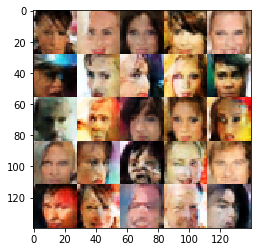

Epoch 4/4... Discriminator Loss: 0.4706... Generator Loss: 2.2189
Epoch 4/4... Discriminator Loss: 0.8835... Generator Loss: 2.4669
Epoch 4/4... Discriminator Loss: 1.2474... Generator Loss: 0.5441
Epoch 4/4... Discriminator Loss: 1.1506... Generator Loss: 0.7462
Epoch 4/4... Discriminator Loss: 1.1189... Generator Loss: 1.0146


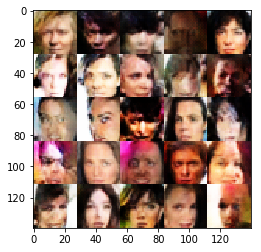

Epoch 4/4... Discriminator Loss: 1.3207... Generator Loss: 0.6011
Epoch 4/4... Discriminator Loss: 1.1696... Generator Loss: 0.5781
Epoch 4/4... Discriminator Loss: 0.8565... Generator Loss: 1.3539
Epoch 4/4... Discriminator Loss: 1.1469... Generator Loss: 0.8247
Epoch 4/4... Discriminator Loss: 1.0094... Generator Loss: 1.0871


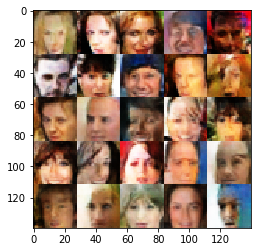

Epoch 4/4... Discriminator Loss: 1.2926... Generator Loss: 0.5927
Epoch 4/4... Discriminator Loss: 1.5316... Generator Loss: 0.3391
Epoch 4/4... Discriminator Loss: 1.2792... Generator Loss: 1.4403


In [13]:
batch_size = 64
z_dim = 110
learning_rate = 0.0008
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 4

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.